# Example RMSD Analysis

This notebook is intended as a starting point for analysis of specific data. 

Here are some helpful resources (I (Caitlin) have not used all of them so feel free to add or remove anything that is(n't) useful.

### Pandas

Pandas is a very useful (and popular) python library for processing data. I like to think of it like an excell file, it is basically a matrix with labeled columns. That means you can access data based on a label instead of just an index as in a typical python list or array. 

* [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/)
* [10 minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html#min)
* [tutorials point](https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm)

### Seaborn

Python's main plotting library is matplotlib. Seaborn is a library that takes advantage of matplotlib, but is generally a little easier to use and works well with pandas. 

* [Seaborn documentation](https://seaborn.pydata.org/)
* [Data Camp tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial)

### Numpy

Initially this notebook isn't using Numpy directly, but it is an extremely useful library you should be aware of. It works mostly with a data structure called arrays which are a normal matrix. It allows you to do most mathematical opporations on those structures

* [introductory tutorial from numpy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html)

### OEnotebook

OEnotebook is a useful jupyter notebook integration of the openeye tools for visualizing molecules, it interacts well with pandas as well. There are some great [examples online](http://notebooks.eyesopen.com/category/novice.html)

## Relevant conda/pip commands

If you are missing any of these packages they are all installable via conda or pip by the commands below. Openeye packages require a license. 

```
conda install pandas
conda install seaborn
conda install -c openeye openeye-toolkits
pip install --pre --extra-index-url https://pypi.anaconda.org/OpenEye/channel/beta/simple OpenEye-oenotebook
```

In [1]:
# helpful tools from openeye
import oenotebook as oenb
from openeye import oechem

import pandas as pd

import matplotlib
import seaborn as sns
import numpy as np
# Allows plots to show in notebook
% matplotlib inline

# Save data locations

In this example, we'll consider the two molecules used in the [examples on github](https://github.com/MobleyLab/off-ffcompare/tree/master/examples). 

First we will store the relevant data as global variables we can use throughout the notebook. 

In [7]:
def smi_file_to_mol_dict(smi_file):
    """
    This method returns a dictionary of the form 
    {molname: OEMol}
    for the molecules found in the input SMILES file
    """
    mol_dict = dict()
    ifs = oechem.oeifstream(smi_file)
    mol = oechem.OEMol()
    return mol_dict
    
    
SMI_FILE = './examples/example_molecules.smi'
mol_dict = dict()
ifs.close()
ifs = oechem.oeifstream(SMI_FILE)
mol = oechem.OEMol()
while oechem.OEReadMolecule(ifs, mol):
    mol_dict[mol.GetTitle()] = oechem.OEMol(mol)
ifs.close()

NotImplementedError: Wrong number or type of arguments for overloaded function 'OEReadMolecule'.
  Possible C/C++ prototypes are:
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEMCMolBase &)
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEQMolBase &)
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEMolBase &)
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEMol &)
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEQMol &)
    OEChem::OEReadMolecule(OEChem::oemolistream &,OEChem::OEGraphMol &)
    OEChem::OEReadMolecule(OEChem::oemolithread &,OEChem::OEMolBase &)
    OEChem::OEReadMolecule(OEChem::oemolithread &,OEChem::OEMCMolBase &)
    OEChem::OEReadMolecule(OEChem::oemolithread &,OEChem::OEQMolBase &)


### Visualize molecules that were chosen for these calculations

In [3]:
def parse_smi_file_txt(smi):
    f = open(smi, 'r')
    lines = f.readlines()
    f.close()
    
    smiles = list()
    label = list()
    for l in lines:
        split = l.split()
        smiles.append(split[0])
        label.append(split[1])
    return smiles, label

def smiles_to_mol(smiles):
    mol = oechem.OEMol()
    if oechem.OESmilesToMol(mol, smiles):
        oechem.OEPerceiveChiral(mol)
        return mol
    else:
        return None

In [4]:
smi_file = 'carbon.smi'
d = dict()
d['smiles'], d['labels'] = parse_smi_file_txt(smi_file)
df = pd.DataFrame(d)
df['Molecule'] = df.smiles.apply(smiles_to_mol)
for [label, mol] in df[['labels', 'Molecule']].values:
    mol.SetTitle(label)

In [5]:
for mol in df.Molecule.values:
    for bond in mol.GetBonds():
        cip = oechem.OEPerceiveCIPStereo(mol, bond)
    charge_molecule(mol)

,labels,smiles,Molecule
0,s1,CC,
1,s2,CCC,
2,s3,C1CC1,
3,s4,CCCC,
4,s5,CC(C)C,
5,s6,C1CCC1,
6,s7,CCCCC,
7,s8,CC(C)(C)C,
8,s9,C1CCCC1,
9,d0,C=C,

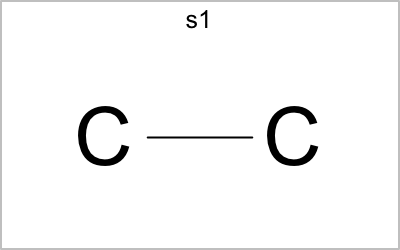
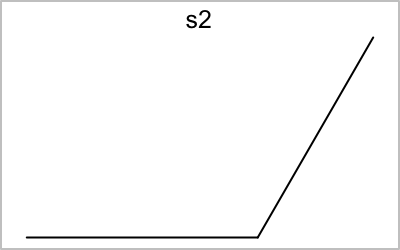
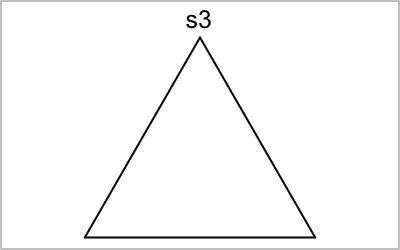
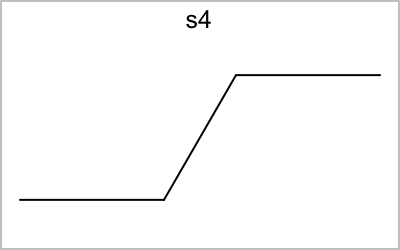
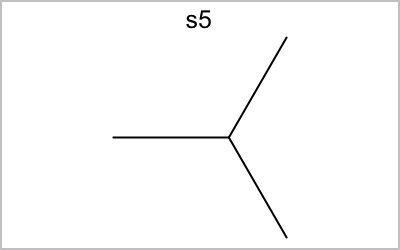
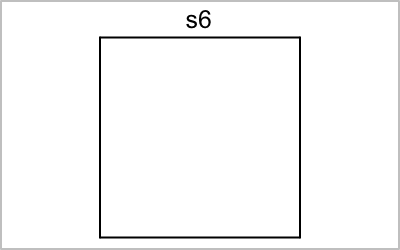
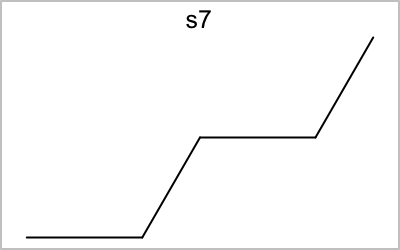
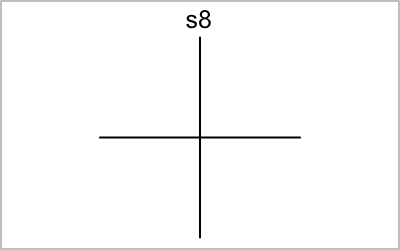
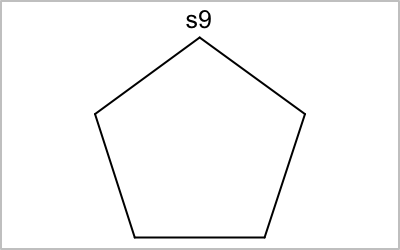
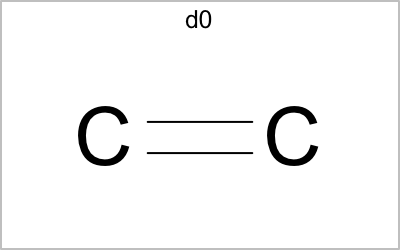
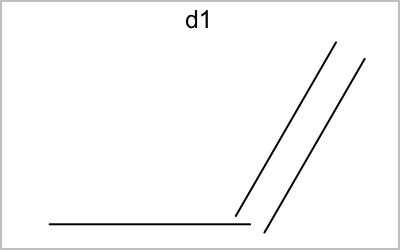
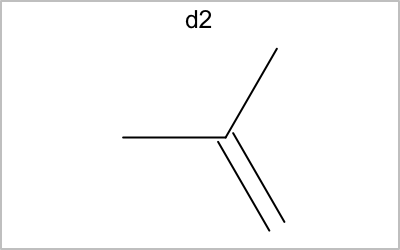
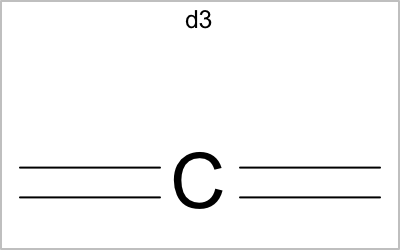
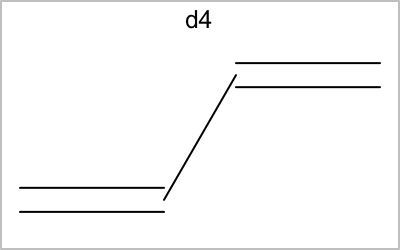
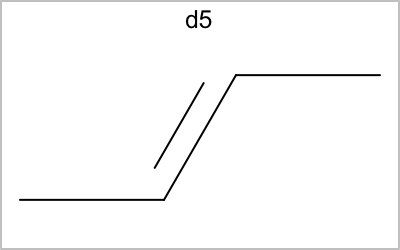
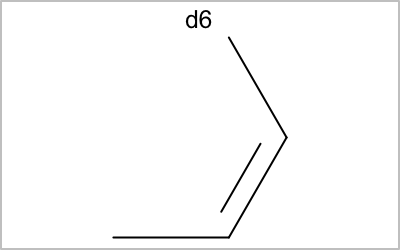
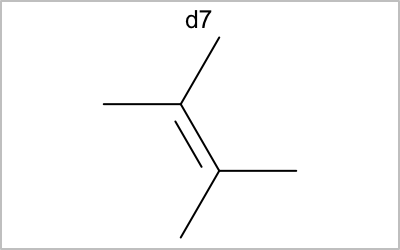
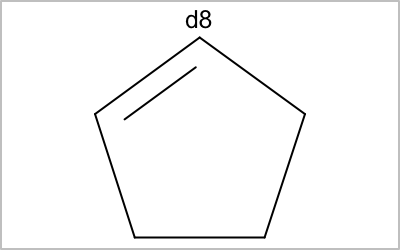
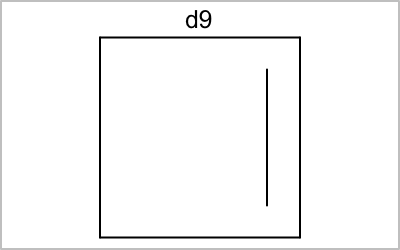
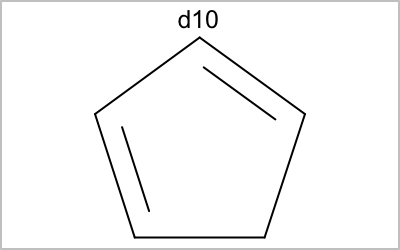
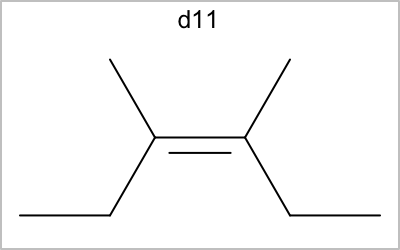
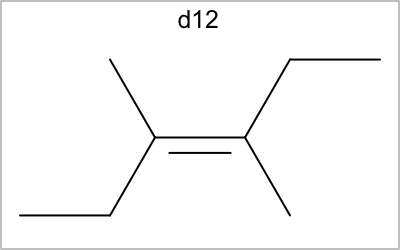
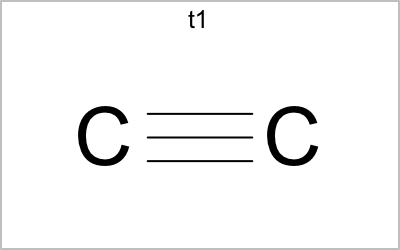
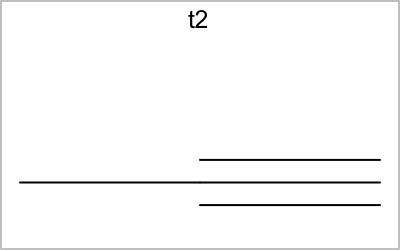
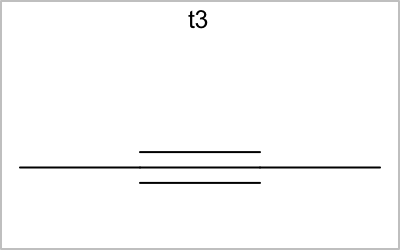
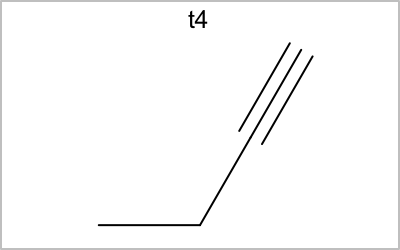
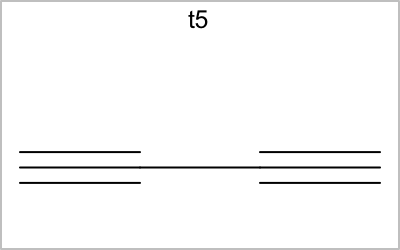
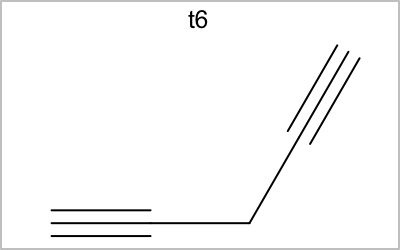
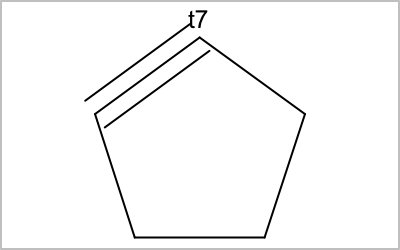
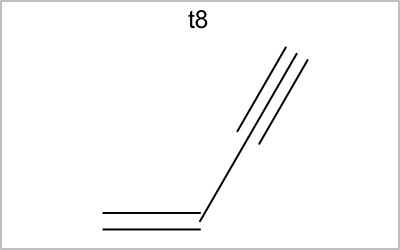
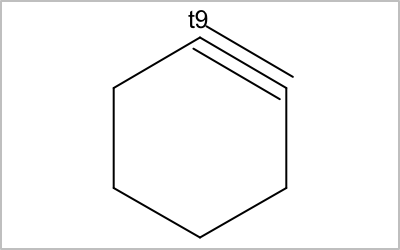
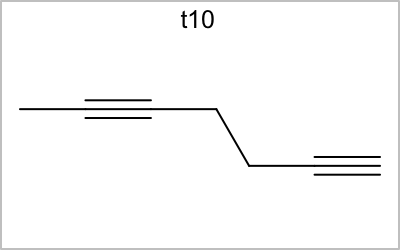
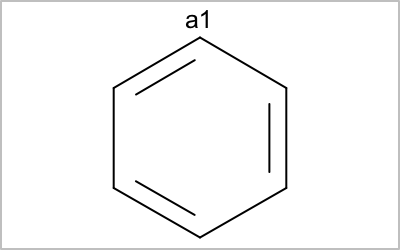
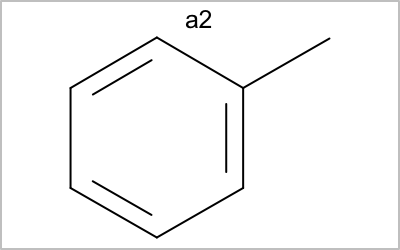
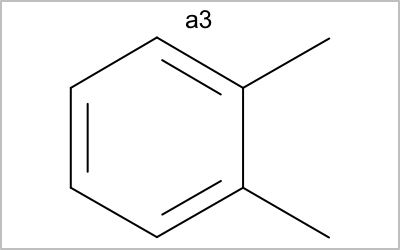
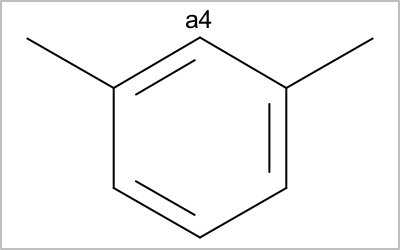
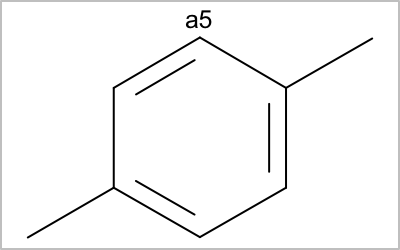
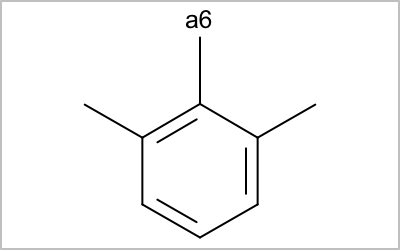
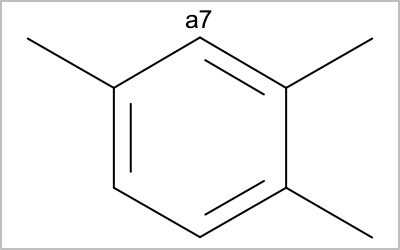
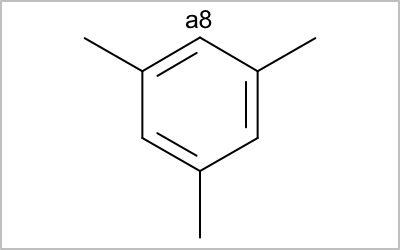
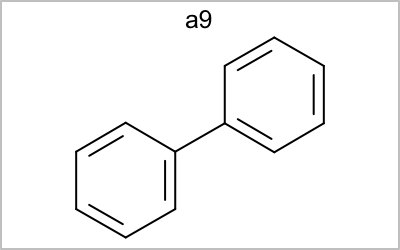
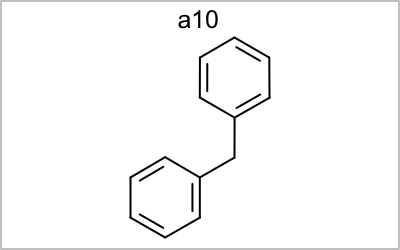
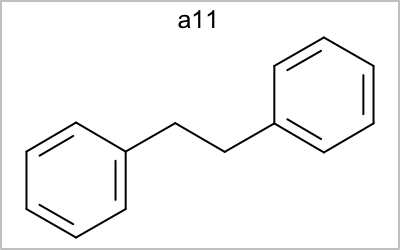
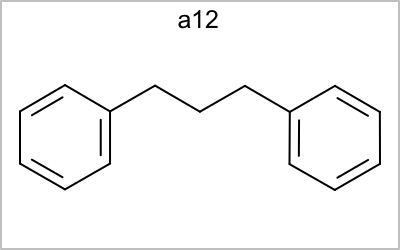

In [6]:
oenb.render_dataframe(df)

# ---------------------------------------------------------------------------------------

# Visualize Bond Lengths

From minimized structures, extract length between bonded carbon atoms

In [10]:
molecules_file = 'carbon-220.sdf'
molecules = list()
for mol in read_molecules(molecules_file):
    oechem.OEPerceiveChiral(mol)
    oechem.OEPerceiveBondOrders(mol)
    #for bond in mol.GetBonds():
    #    oechem.OEPerceiveChiral(bond)
    #    c = oechem.OEPerceiveCIPStereo(mol, bond)
    #    if mol.GetTitle() in ['d5', 'd6', 'd11']:
    #        if bond.GetOrder() == 2:
    #            print(mol.GetTitle(), c)
    #charged = charge_molecule(mol)
    molecules.append(mol)
titles = {mol.GetTitle(): 0 for mol in molecules}
for mol in molecules:
    titles[mol.GetTitle()] += 1

Loading molecules from 'carbon-220.sdf'...
61 molecules read
0.063 s elapsed


In [11]:
def get_bond_lengths(mol,smirks='[#6:1]~[#6:2]'):
    """
    Returns a list of bond lengths that match the provided SMIRKS
    
    Parameters
    ----------
    mol - OEMol for a single conformer
    """
    bond_indices = getSMIRKSMatches_OEMol(mol, smirks)
    
    lengths = list()
    for (a1, a2) in bond_indices:
        lengths.append(oechem.OEGetDistance(mol, 
                                             mol.GetAtom(oechem.OEHasAtomIdx(a1)), 
                                             mol.GetAtom(oechem.OEHasAtomIdx(a2))))
    
    return lengths

def get_bond_angles(mol, smirks='[*:1]~[#6:2]~[*:3]'):
    """
    Returns a list of bond lengths that match the provided SMIRKS
    
    Parameters
    ----------
    mol - OEMol for a single conformer
    """
    bond_indices = getSMIRKSMatches_OEMol(mol, smirks)
    
    angles = list()
    for (a1, a2, a3) in bond_indices:
        radians = oechem.OEGetAngle(mol, mol.GetAtom(oechem.OEHasAtomIdx(a1)), 
                                    mol.GetAtom(oechem.OEHasAtomIdx(a2)), mol.GetAtom(oechem.OEHasAtomIdx(a3)))
        angles.append(np.math.degrees(radians))
    
    return angles

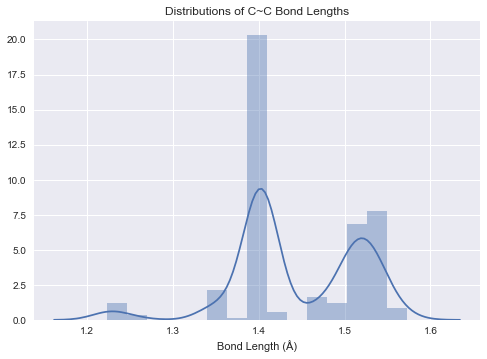

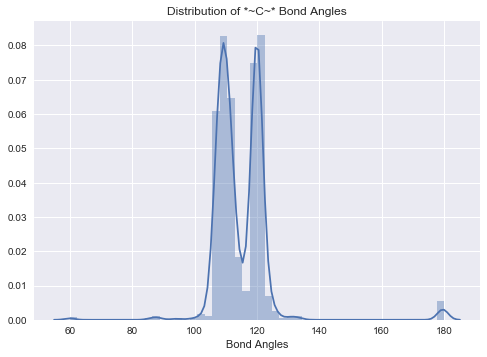

In [13]:
def plot_distributions(molecules, bond=True):
    """
    plot a distribution of either bond lengths (if bond=True) or angles (if bond=False)
    """
    bond_lens = list()
    bond_charges = list()
    bond_angles = list()
    for mol in molecules:
        #l, c = get_bond_lengths(mol)
        bond_lens += get_bond_lengths(mol)
        bond_angles += get_bond_angles(mol)
    
    f = sns.plt.figure()
    ax = sns.distplot(pd.Series(bond_lens, name="Bond Length (Å)"))
    ax.set_title("Distributions of C~C Bond Lengths")
    
    f2 = sns.plt.figure()
    ax2 = sns.distplot(pd.Series(bond_angles, name="Bond Angles"))
    ax2.set_title("Distribution of *~C~* Bond Angles")
    return f, f2

f, f2 = plot_distributions(molecules)

In [15]:
f.savefig('bond_lengths.png')
f2.savefig('bond_angles.png')